# Exercises 5

*Antti Härkönen*

## 1.

Posterior distribution of the latent variables factorises if they are independent, i.e.
 $ z_n \perp\!\!\!\perp z_{m \neq n} \mid x_n, \mu, \sigma^2, \pi $. The hyperparameter $\pi$ is the only node from which
 $\bf Z$ nodes can be reached, and since it is always a fork between z child nodes, path through it is blocked.


## 2.

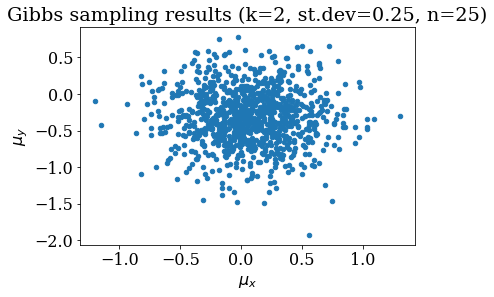

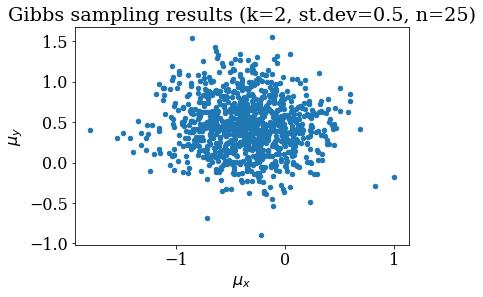

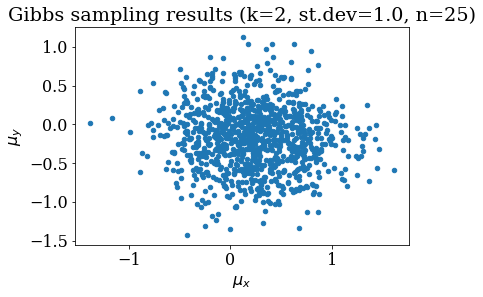

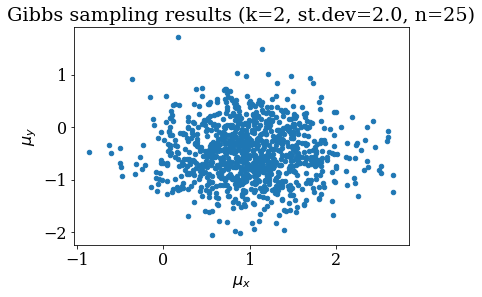

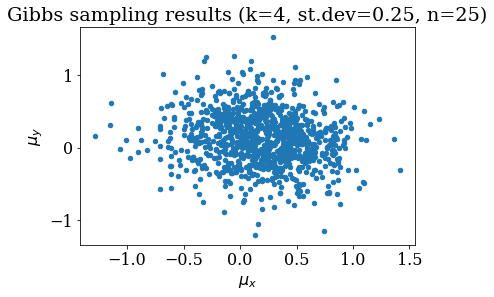

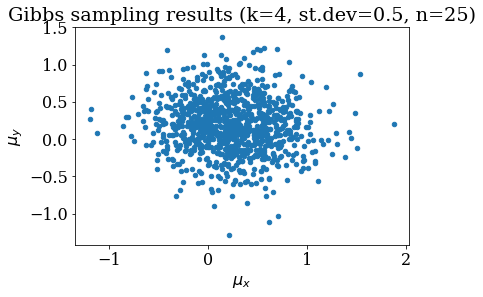

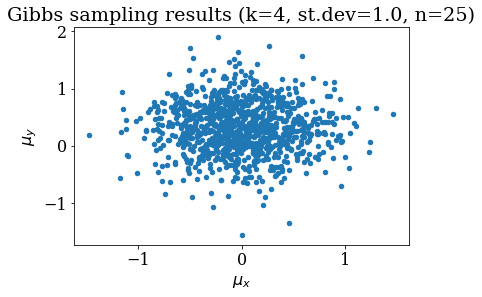

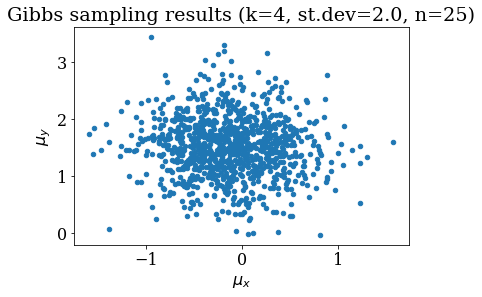

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions


class GibbsSampler:
    def __init__(self, data, iterations=1000, burn_in=100):
        self.N, self.M = data.shape
        self.X = data
        self.iterations = iterations
        self.burn_in = burn_in
        self.samples = []
        mu = np.random.uniform(data.min(), data.max(), size=self.M)
        z = tfd.OneHotCategorical(logits=np.ones(self.M)).sample(self.N).numpy()
        var = np.ones(self.M)
        self.samples.append({'t': 0, 'mu': mu.copy(), 'z': z.copy()})
        x_bar = 1

        for t in range(1, self.iterations + self.burn_in + 1):
            for n in range(self.N):
                z[n] = tfd.OneHotCategorical(
                    logits=tfd.Normal(mu, var).prob(self.X[n])
                ).sample(1).numpy()
            for m in range(self.M):
                members = z[:, m].sum()
                if members != 0:
                    x_bar = (z[:, m] * self.X[:, m]).sum() / members
                lambda_hat = 1 / (members / var[m] + t**(-2))
                mu_hat = lambda_hat * (members / var[m] * x_bar + mu[m] / t**2)
                mu[m] = np.random.normal(
                    loc=mu_hat,
                    scale=lambda_hat**0.5,
                    size=1,
                )
            self.samples.append({'t': t, 'mu': mu.copy(), 'z': z.copy()})

    def sample(self, n):
        return self.samples[self.burn_in + n]

    @property
    def mu(self):
        return [el['mu'] for el in self.samples[self.burn_in:]]

    def plot(self, **kwargs):
        df = pd.DataFrame(self.mu, columns=[r'$\mu_x$', r'$\mu_y$'])
        df.plot(x=r'$\mu_x$', y=r'$\mu_y$', kind='scatter', **kwargs)


n = 25
K = 2, 4
sigmas = 0.25, 0.5, 1., 2.

for k in K:
    for sigma_0 in sigmas:
        alpha = np.ones(k, dtype=np.float)
        theta = tfd.Dirichlet(alpha).sample(1).numpy()
        z = tfd.Categorical(probs=theta).sample(n).numpy()

        mu_x = tfd.Normal(np.zeros(k), np.repeat(sigma_0, k)).sample(n).numpy()
        mu_zx = np.squeeze(np.take_along_axis(mu_x, z, 1))
        x = np.squeeze(tfd.Normal(mu_zx, np.ones(n)).sample(1).numpy())

        mu_y = tfd.Normal(np.zeros(k), np.repeat(sigma_0, k)).sample(n).numpy()
        mu_zy = np.squeeze(np.take_along_axis(mu_y, z, 1))
        y = np.squeeze(tfd.Normal(mu_zy, np.ones(n)).sample(1).numpy())

        xy = pd.DataFrame({'x': x, 'y': y, 'k': np.squeeze(z)})

        gs = GibbsSampler(
            xy.loc[:, ['x', 'y']].values,
            burn_in=100,
            iterations=1000,
        )
        gs.plot(title=f"Gibbs sampling results (k={k}, st.dev={sigma_0}, n={n})")

The results seem to converge around the real mean $ \begin{pmatrix} 0 \\ 0 \end{pmatrix} $ as expected.
Some plots are multimodal which is expected as there are different clusters.

## 3.

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\antth\Anaconda3\envs\BAY1\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [mu_T]
>>Metropolis: [sigma2_T]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [z]
Sampling 2 chains for 50 tune and 100 draw iterations (

ValueError: cannot convert float NaN to integer

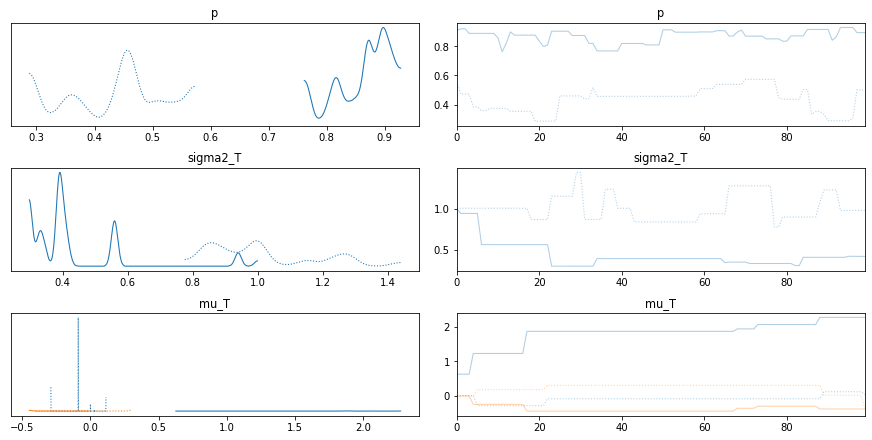

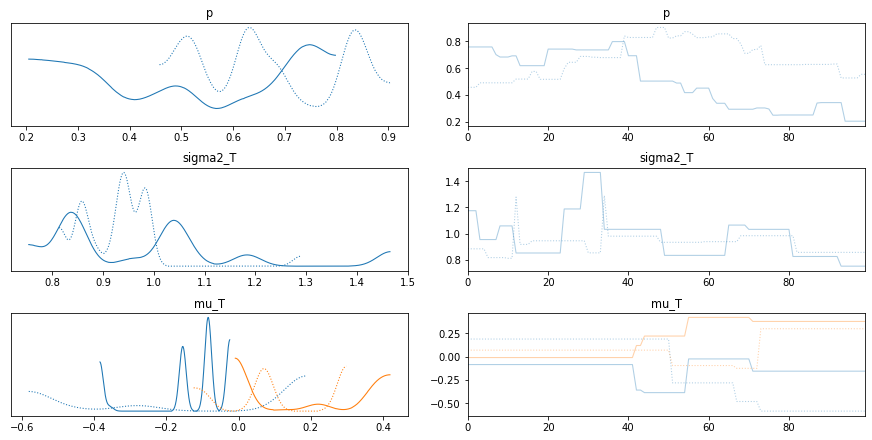

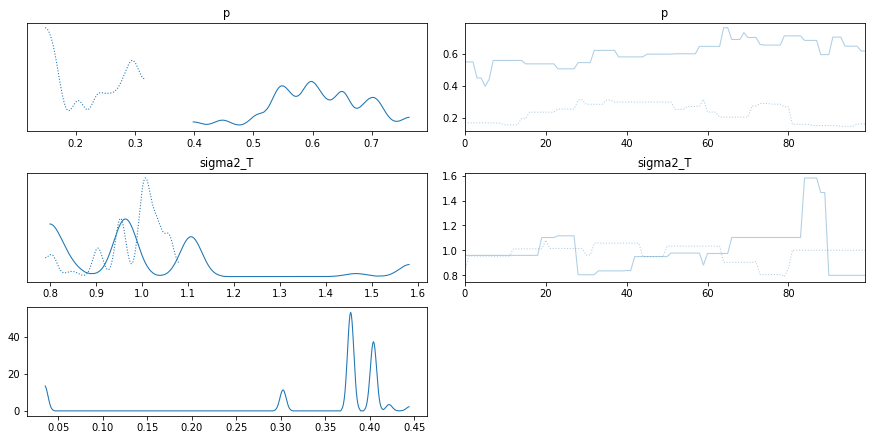

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm

data = pd.read_csv('fish.csv', sep=';')

for allas in data.Allas.unique():
    tank = data.loc[data.Allas == allas].copy()
    tank['norm_pituus'] = (tank.Pituus - tank.Pituus.mean()) / tank.Pituus.std()

    with pm.Model() as model:
        n, _ = tank.shape
        p = pm.Beta('p', 1, 1)
        z = pm.Bernoulli('z', p, shape=n)
        mu_T = pm.Normal('mu_T', mu=0, sigma=1, shape=2)
        sigma2_T = pm.InverseGamma('sigma2_T', 1, 1)
        obs = pm.Normal(
            'obs',
            mu_T[z],
            sigma=np.sqrt(sigma2_T),
            observed=tank.norm_pituus,
        )

        step1 = pm.Metropolis(vars=[p, sigma2_T, mu_T])
        step2 = pm.CategoricalGibbsMetropolis(vars=[z])
        tr = pm.sample(100, step=[step1, step2], tune=50)
        pm.traceplot(tr, var_names=['mu_T'])

There seems to two different distributions in the length of the fish, likely explained by the two different kind of fish.